In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [75]:
df = pd.read_csv('cleaned_data_onehot.csv')

In [76]:
df.head(10)

,Price,RAM_Expandable,RAM_Capacity,RAM_TYPE(DDR),Display_type,Processor_Tier,Processor_Speed(Ghz),Display_Tier,GPU_Tier,SSD(GB),...,Brand_HP,Brand_Lenovo,Brand_MSI,Brand_Other,Brand_Samsung,Processor_Apple,Processor_Intel,GPU_Apple,GPU_Intel,GPU_NVIDIA
0,127011.5,1,8,3,0,1.0,4.0,1,1,512,...,False,True,False,False,False,False,False,False,False,False
1,274750.0,1,16,5,0,1.0,3.5,1,3,512,...,False,False,False,False,False,False,True,False,False,True
2,194215.0,1,8,3,0,1.0,4.0,1,2,512,...,True,False,False,False,False,False,True,False,True,False
3,76965.0,0,8,4,0,0.0,1.5,1,1,512,...,False,False,False,True,False,False,True,False,True,False
4,122465.0,1,16,3,0,1.0,2.5,1,2,512,...,False,False,False,False,False,False,True,False,True,False
5,173596.5,1,8,3,0,1.0,4.0,1,1,512,...,True,False,False,False,False,False,False,False,False,False
6,139965.0,1,8,3,0,1.0,2.5,1,2,512,...,False,False,False,False,False,False,True,False,True,False
7,115888.5,1,4,3,1,0.0,2.0,1,1,0,...,False,True,False,False,False,False,True,False,True,False
8,171465.0,0,8,3,0,1.0,3.0,1,3,512,...,False,False,False,False,False,False,True,False,False,True
9,325465.0,1,16,5,0,2.0,3.5,1,3,512,...,False,True,False,False,False,False,False,False,False,True


### Feature-Target Split

In [77]:
# Target variable
y = df["Price"]

# drop target column
X = df.drop(columns=["Price"])

print("Features shape:", X.shape)
print("Target shape:", y.shape)

# Here I verify all features are numeric
print("\nFeature types:\n", X.dtypes.value_counts())

Features shape: (3724, 23)
Target shape: (3724,)

Feature types:
 bool       13
int64       8
float64     2
Name: count, dtype: int64


### Train-Test Split

In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 2979 samples
Test set: 745 samples


### Base Model

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 2979, number of used features: 21
[LightGBM] [Info] Start training from score 248823.821081
Baseline LightGBM Performance:
RMSE: 73681.22
MAE: 44879.11
R² Score: 0.7959


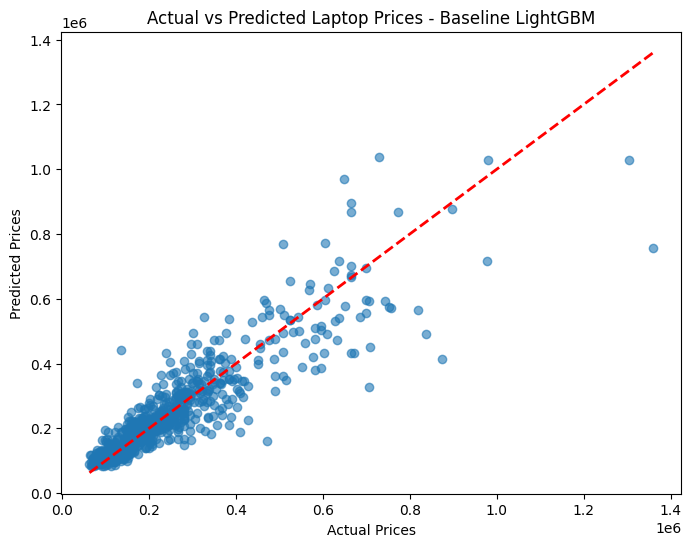

In [79]:
# Initialize baseline LGBMRegressor with default parameters
baseline_model = lgb.LGBMRegressor(random_state=42)

# Train the model
baseline_model.fit(X_train, y_train)

# Make predictions on test data
y_pred = baseline_model.predict(X_test)


# Evaluate Baseline Performance

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE
mae = mean_absolute_error(y_test, y_pred)           # MAE
r2 = r2_score(y_test, y_pred)                       # R² score

print("Baseline LightGBM Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Visualize actual vs predicted prices
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Laptop Prices - Baseline LightGBM")
plt.show()

### Hyper parameter tuning 

In [80]:
# from sklearn.model_selection import RandomizedSearchCV

# # new model initialization
# tuning_model = lgb.LGBMRegressor(
#     objective='regression',
#     random_state=42,
#     n_estimators=1000 
# )

# # parameter grid
# param_dist = {
#     'num_leaves': [31, 50, 70, 100],
#     'max_depth': [-1, 10, 20, 30],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'min_child_samples': [10, 20, 30, 50],
#     'subsample': [0.7, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 1.0],
#     'lambda_l1': [0, 0.1, 0.5, 1.0],
#     'lambda_l2': [0, 0.1, 0.5, 1.0]
# }

# # randomized search
# random_search = RandomizedSearchCV(
#     estimator=tuning_model,
#     param_distributions=param_dist,
#     n_iter=50, # 50 random combinations are considered
#     scoring='neg_root_mean_squared_error',
#     cv=5,       
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# # Fit the search on the training data
# random_search.fit(X_train, y_train)

In [81]:
# print("\nBest Parameters found by RandomizedSearchCV:")
# print(random_search.best_params_)
# print(f"Best CV RMSE: {-random_search.best_score_:.2f}")

Top 10 Important Features:
                 Feature  Importance
5   Processor_Speed(Ghz)         574
2          RAM_TYPE(DDR)         333
4         Processor_Tier         269
7               GPU_Tier         252
8                SSD(GB)         222
1           RAM_Capacity         181
0         RAM_Expandable         164
3           Display_type         124
6           Display_Tier         118
19       Processor_Intel         110


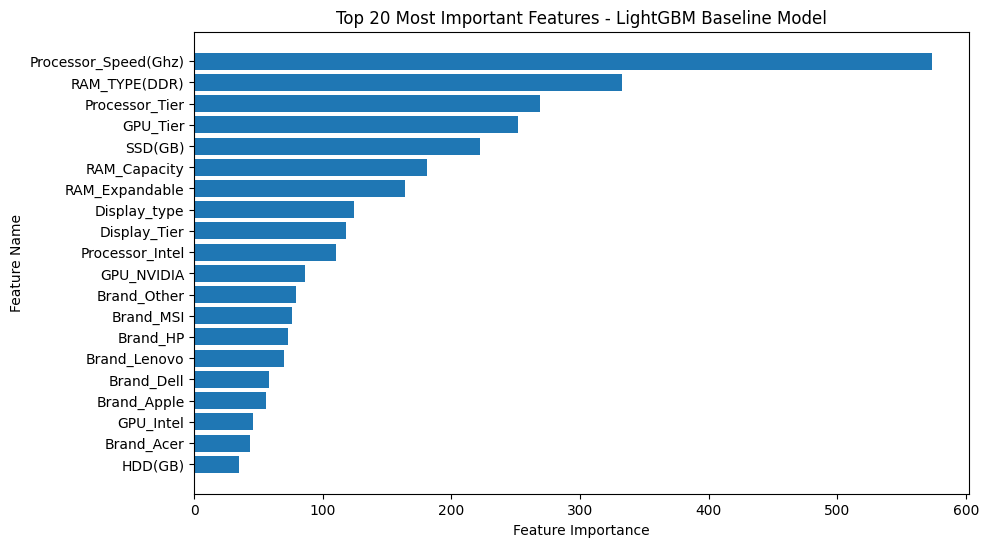

In [82]:
# Get feature importances and sort them
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': baseline_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display top features
print("Top 10 Important Features:")
print(feature_importances.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:20][::-1], feature_importances['Importance'][:20][::-1])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Top 20 Most Important Features - LightGBM Baseline Model")
plt.show()

In [83]:
print(feature_importances.head(30))

                 Feature  Importance
5   Processor_Speed(Ghz)         574
2          RAM_TYPE(DDR)         333
4         Processor_Tier         269
7               GPU_Tier         252
8                SSD(GB)         222
1           RAM_Capacity         181
0         RAM_Expandable         164
3           Display_type         124
6           Display_Tier         118
19       Processor_Intel         110
22            GPU_NVIDIA          86
16           Brand_Other          79
15             Brand_MSI          76
13              Brand_HP          73
14          Brand_Lenovo          70
12            Brand_Dell          58
11           Brand_Apple          56
21             GPU_Intel          46
10            Brand_Acer          43
9                HDD(GB)          35
17         Brand_Samsung          31
18       Processor_Apple           0
20             GPU_Apple           0
